In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
train = pd.read_csv('/work/home/ybchae/aimers/aimers_data/train.csv').drop(columns=['ID'])
test = pd.read_csv('/work/home/ybchae/aimers/aimers_data/test.csv').drop(columns=['ID'])
train.shape, test.shape

((256351, 68), (90067, 67))

In [6]:
train.head()

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


In [7]:
train['임신 성공 여부'].value_counts()

0    190123
1     66228
Name: 임신 성공 여부, dtype: int64

In [8]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()

만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: 시술 당시 나이, dtype: int64

In [9]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [10]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [11]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [12]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [13]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [14]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [15]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [104]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형',
       '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '배아 생성 주요 이유', '총 시술 횟수',
       '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수',
       'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수',
       '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처',
       '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부',
       '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일',
       '배아 해동 경과일', '임신 성공 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [16]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', 'PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = [ '임신 시도 또는 마지막 임신 경과 연수',"총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '총 생성 배아 수','미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [17]:
len(categorical_columns) + len(numeric_columns)

58

In [18]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [19]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 66), (90067, 66))

In [55]:
y.value_counts()

,count
임신 성공 여부,
0,190123
1,66228


In [40]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1000, 3000),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)

    return model_cat.get_best_score()["validation"]["AUC"]

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
         "random_state":  trial.suggest_int('random_state', 42, 42),
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5, log=False),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1, log=False),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params,class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [41]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 10)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds= 300,eval_set=[(X_val,y_val)], verbose = 300)

    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 20)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    #lgbm_trial_params ={'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}
    print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print(roc_auc_score(y_val,val_pred_lgbm))

    roc_val = roc_auc_score(y_val, (val_pred+val_pred_lgbm)/2)
    scores_total.append(roc_val)
    print(roc_val)

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred+test_pred_lgbm)/2)

[I 2025-02-17 10:36:41,549] A new study created in memory with name: no-name-9cd10df4-a045-4545-a2a5-44cd0fb41c0c


Seed 42 Start!
0:	test: 0.7029731	best: 0.7029731 (0)	total: 83.6ms	remaining: 2m 26s
300:	test: 0.7437051	best: 0.7438239 (241)	total: 16.4s	remaining: 1m 18s


[I 2025-02-17 10:37:11,704] Trial 0 finished with value: 0.743823855542183 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.743823855542183.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438238555
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 69.9ms	remaining: 2m 52s
300:	test: 0.7436279	best: 0.7436689 (291)	total: 16.2s	remaining: 1m 56s
600:	test: 0.7435144	best: 0.7436727 (334)	total: 32.9s	remaining: 1m 41s


[I 2025-02-17 10:37:46,835] Trial 1 finished with value: 0.7436726997959286 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 0 with value: 0.743823855542183.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436726998
bestIteration = 334

Shrink model to first 335 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 75.3ms	remaining: 1m 38s
300:	test: 0.7420398	best: 0.7420398 (300)	total: 16s	remaining: 53.8s
600:	test: 0.7432486	best: 0.7432594 (597)	total: 31.9s	remaining: 37.7s
900:	test: 0.7437359	best: 0.7437565 (879)	total: 48.4s	remaining: 22.1s
1200:	test: 0.7438271	best: 0.7438797 (1066)	total: 1m 5s	remaining: 6.01s


[I 2025-02-17 10:38:58,462] Trial 2 finished with value: 0.7438828876026947 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 2 with value: 0.7438828876026947.


1311:	test: 0.7438802	best: 0.7438829 (1299)	total: 1m 11s	remaining: 0us

bestTest = 0.7438828876
bestIteration = 1299

Shrink model to first 1300 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 66.1ms	remaining: 1m 13s
300:	test: 0.7434304	best: 0.7434333 (297)	total: 16.3s	remaining: 44.2s
600:	test: 0.7430763	best: 0.7435871 (362)	total: 33.1s	remaining: 28.3s


[I 2025-02-17 10:39:35,278] Trial 3 finished with value: 0.7435871316985297 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 2 with value: 0.7438828876026947.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435871317
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 68.5ms	remaining: 2m 30s
300:	test: 0.7434765	best: 0.7435082 (267)	total: 16.3s	remaining: 1m 42s
600:	test: 0.7436379	best: 0.7436532 (589)	total: 33s	remaining: 1m 27s


[I 2025-02-17 10:40:24,749] Trial 4 finished with value: 0.7436532236234117 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 2 with value: 0.7438828876026947.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436532236
bestIteration = 589

Shrink model to first 590 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 69.1ms	remaining: 1m 11s
300:	test: 0.7430549	best: 0.7433350 (183)	total: 16.4s	remaining: 40.4s


[I 2025-02-17 10:40:51,408] Trial 5 finished with value: 0.7433350055973448 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 2 with value: 0.7438828876026947.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433350056
bestIteration = 183

Shrink model to first 184 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 64.5ms	remaining: 2m 51s
300:	test: 0.7422682	best: 0.7422682 (300)	total: 15.9s	remaining: 2m 5s
600:	test: 0.7434498	best: 0.7434498 (600)	total: 31.9s	remaining: 1m 49s
900:	test: 0.7436773	best: 0.7437228 (795)	total: 48.2s	remaining: 1m 34s
1200:	test: 0.7438163	best: 0.7438285 (1195)	total: 1m 4s	remaining: 1m 19s
1500:	test: 0.7438448	best: 0.7438629 (1371)	total: 1m 21s	remaining: 1m 3s


[I 2025-02-17 10:42:22,816] Trial 6 finished with value: 0.7438628595060228 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 2 with value: 0.7438828876026947.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438628595
bestIteration = 1371

Shrink model to first 1372 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 78.7ms	remaining: 1m 47s
300:	test: 0.7424229	best: 0.7424243 (299)	total: 16.1s	remaining: 56.8s
600:	test: 0.7433793	best: 0.7433793 (600)	total: 31.9s	remaining: 40.4s
900:	test: 0.7437817	best: 0.7437837 (898)	total: 48.5s	remaining: 24.9s
1200:	test: 0.7438914	best: 0.7439090 (1162)	total: 1m 5s	remaining: 8.8s


[I 2025-02-17 10:43:37,552] Trial 7 finished with value: 0.7439089948064255 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 7 with value: 0.7439089948064255.


1362:	test: 0.7438772	best: 0.7439090 (1162)	total: 1m 14s	remaining: 0us

bestTest = 0.7439089948
bestIteration = 1162

Shrink model to first 1163 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 71.8ms	remaining: 1m 55s
300:	test: 0.7433930	best: 0.7433930 (300)	total: 16.1s	remaining: 1m 10s
600:	test: 0.7435511	best: 0.7435748 (595)	total: 32.7s	remaining: 54.7s


[I 2025-02-17 10:44:27,038] Trial 8 finished with value: 0.7435747670091887 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 7 with value: 0.7439089948064255.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743574767
bestIteration = 595

Shrink model to first 596 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 75.3ms	remaining: 2m 20s
300:	test: 0.7428068	best: 0.7428068 (300)	total: 16s	remaining: 1m 23s
600:	test: 0.7437785	best: 0.7437981 (596)	total: 32.3s	remaining: 1m 7s
900:	test: 0.7437219	best: 0.7438268 (638)	total: 49s	remaining: 52.3s


[I 2025-02-17 10:45:18,459] Trial 9 finished with value: 0.7438268216381809 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 7 with value: 0.7439089948064255.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438268216
bestIteration = 638

Shrink model to first 639 iterations.
0:	test: 0.7029731	best: 0.7029731 (0)	total: 73.7ms	remaining: 1m 40s
300:	test: 0.7424229	best: 0.7424243 (299)	total: 16.2s	remaining: 57s
600:	test: 0.7433793	best: 0.7433793 (600)	total: 31.6s	remaining: 40.1s
900:	test: 0.7437817	best: 0.7437837 (898)	total: 47.9s	remaining: 24.6s
1200:	test: 0.7438914	best: 0.7439090 (1162)	total: 1m 4s	remaining: 8.65s


[I 2025-02-17 10:46:32,067] A new study created in memory with name: no-name-582adc89-382c-4e84-aec4-c9a8883d703d


1362:	test: 0.7438772	best: 0.7439090 (1162)	total: 1m 13s	remaining: 0us

bestTest = 0.7439089948
bestIteration = 1162

Shrink model to first 1163 iterations.


[I 2025-02-17 10:46:42,943] Trial 0 finished with value: 0.7429013718920625 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7429013718920625.
[I 2025-02-17 10:46:44,894] Trial 1 finished with value: 0.7399748595767962 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7429013718920625.
[I 2025-02-17 10:46:57,161] Trial 2 finished with value: 0.7439483759846158 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005593066320046345, 'n_estimators': 1996, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.6}
0.7439849578352579
0.7442165237690028


[I 2025-02-17 10:48:48,961] A new study created in memory with name: no-name-1e7b16d9-ff2a-4495-ba23-7ec4357e751e


0:	test: 0.7109930	best: 0.7109930 (0)	total: 74.5ms	remaining: 2m 10s
300:	test: 0.7322492	best: 0.7324940 (196)	total: 16s	remaining: 1m 16s


[I 2025-02-17 10:49:15,944] Trial 0 finished with value: 0.7324939517848531 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7324939517848531.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7324939518
bestIteration = 196

Shrink model to first 197 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 67.8ms	remaining: 2m 47s
300:	test: 0.7323898	best: 0.7324269 (290)	total: 16.1s	remaining: 1m 55s
600:	test: 0.7324658	best: 0.7326383 (428)	total: 32.6s	remaining: 1m 41s


[I 2025-02-17 10:49:55,966] Trial 1 finished with value: 0.7326383474163023 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 1 with value: 0.7326383474163023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7326383474
bestIteration = 428

Shrink model to first 429 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 69.6ms	remaining: 1m 31s
300:	test: 0.7302454	best: 0.7302454 (300)	total: 15.9s	remaining: 53.4s
600:	test: 0.7316979	best: 0.7317019 (596)	total: 31.4s	remaining: 37.1s
900:	test: 0.7325116	best: 0.7325161 (887)	total: 47.8s	remaining: 21.8s
1200:	test: 0.7325451	best: 0.7325856 (1107)	total: 1m 4s	remaining: 5.96s


[I 2025-02-17 10:51:06,903] Trial 2 finished with value: 0.7325856366567802 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 1 with value: 0.7326383474163023.


1311:	test: 0.7325440	best: 0.7325856 (1107)	total: 1m 10s	remaining: 0us

bestTest = 0.7325856367
bestIteration = 1107

Shrink model to first 1108 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 72ms	remaining: 1m 20s
300:	test: 0.7321100	best: 0.7322044 (213)	total: 16.4s	remaining: 44.3s


[I 2025-02-17 10:51:35,272] Trial 3 finished with value: 0.7322043543527252 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 1 with value: 0.7326383474163023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7322043544
bestIteration = 213

Shrink model to first 214 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 79ms	remaining: 2m 53s
300:	test: 0.7326631	best: 0.7326980 (273)	total: 16.1s	remaining: 1m 41s
600:	test: 0.7326506	best: 0.7329100 (418)	total: 32.6s	remaining: 1m 26s


[I 2025-02-17 10:52:14,777] Trial 4 finished with value: 0.7329099509923769 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 4 with value: 0.7329099509923769.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.732909951
bestIteration = 418

Shrink model to first 419 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 77.5ms	remaining: 1m 20s
300:	test: 0.7328493	best: 0.7330724 (234)	total: 16.3s	remaining: 40.1s


[I 2025-02-17 10:52:44,260] Trial 5 finished with value: 0.7330724000490342 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 5 with value: 0.7330724000490342.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7330724
bestIteration = 234

Shrink model to first 235 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 74.8ms	remaining: 3m 19s
300:	test: 0.7308488	best: 0.7308488 (300)	total: 16.1s	remaining: 2m 6s
600:	test: 0.7322146	best: 0.7322146 (600)	total: 32.1s	remaining: 1m 50s
900:	test: 0.7326329	best: 0.7326892 (783)	total: 48.8s	remaining: 1m 35s
1200:	test: 0.7326543	best: 0.7327563 (1068)	total: 1m 5s	remaining: 1m 19s


[I 2025-02-17 10:53:59,469] Trial 6 finished with value: 0.7327562665440421 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 5 with value: 0.7330724000490342.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7327562665
bestIteration = 1068

Shrink model to first 1069 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 70ms	remaining: 1m 35s
300:	test: 0.7306702	best: 0.7306702 (300)	total: 16.2s	remaining: 57s
600:	test: 0.7320629	best: 0.7320629 (600)	total: 32s	remaining: 40.6s
900:	test: 0.7325742	best: 0.7325767 (899)	total: 48.6s	remaining: 24.9s
1200:	test: 0.7326732	best: 0.7326820 (1189)	total: 1m 5s	remaining: 8.81s


[I 2025-02-17 10:55:14,293] Trial 7 finished with value: 0.732682233998347 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 5 with value: 0.7330724000490342.


1362:	test: 0.7325548	best: 0.7326822 (1214)	total: 1m 14s	remaining: 0us

bestTest = 0.732682234
bestIteration = 1214

Shrink model to first 1215 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 70.7ms	remaining: 1m 53s
300:	test: 0.7326454	best: 0.7326454 (299)	total: 16.2s	remaining: 1m 10s
600:	test: 0.7326163	best: 0.7328917 (502)	total: 32.6s	remaining: 54.7s


[I 2025-02-17 10:55:58,405] Trial 8 finished with value: 0.7328916990033191 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 5 with value: 0.7330724000490342.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.732891699
bestIteration = 502

Shrink model to first 503 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 65.5ms	remaining: 2m 2s
300:	test: 0.7313471	best: 0.7313471 (300)	total: 15.9s	remaining: 1m 22s
600:	test: 0.7324479	best: 0.7324537 (561)	total: 32.1s	remaining: 1m 7s
900:	test: 0.7325872	best: 0.7327625 (788)	total: 48.5s	remaining: 51.8s


[I 2025-02-17 10:56:57,657] Trial 9 finished with value: 0.7327625133627513 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 5 with value: 0.7330724000490342.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7327625134
bestIteration = 788

Shrink model to first 789 iterations.
0:	test: 0.7109930	best: 0.7109930 (0)	total: 78.3ms	remaining: 1m 21s
300:	test: 0.7328493	best: 0.7330724 (234)	total: 16.4s	remaining: 40.4s


[I 2025-02-17 10:57:27,272] A new study created in memory with name: no-name-34b28524-ea2d-40b2-bce9-99605123b467


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7330724
bestIteration = 234

Shrink model to first 235 iterations.


[I 2025-02-17 10:57:38,217] Trial 0 finished with value: 0.7324738769796557 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7324738769796557.
[I 2025-02-17 10:57:40,149] Trial 1 finished with value: 0.7275188670207257 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7324738769796557.
[I 2025-02-17 10:57:52,189] Trial 2 finished with value: 0.732356501916864 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015451581545204445, 'n_estimators': 1574, 'min_child_samples': 40, 'subsample': 0.5, 'colsample_bytree': 0.5}
0.7326602847504091
0.7334558705267118


[I 2025-02-17 10:59:55,134] A new study created in memory with name: no-name-e9514b35-ea95-497f-8116-a530cea28776


0:	test: 0.7182081	best: 0.7182081 (0)	total: 75.8ms	remaining: 2m 12s
300:	test: 0.7387617	best: 0.7388623 (268)	total: 16.3s	remaining: 1m 18s
600:	test: 0.7387191	best: 0.7388766 (320)	total: 32.8s	remaining: 1m 2s


[I 2025-02-17 11:00:29,294] Trial 0 finished with value: 0.7388765563970656 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7388765563970656.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388765564
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 72.4ms	remaining: 2m 58s
300:	test: 0.7388585	best: 0.7388858 (274)	total: 16.3s	remaining: 1m 57s
600:	test: 0.7390416	best: 0.7391484 (468)	total: 32.9s	remaining: 1m 42s
900:	test: 0.7390648	best: 0.7392468 (690)	total: 49.8s	remaining: 1m 26s


[I 2025-02-17 11:01:24,544] Trial 1 finished with value: 0.7392467786946962 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 1 with value: 0.7392467786946962.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392467787
bestIteration = 690

Shrink model to first 691 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 69.4ms	remaining: 1m 31s
300:	test: 0.7360752	best: 0.7360752 (300)	total: 16s	remaining: 53.7s
600:	test: 0.7380157	best: 0.7380157 (600)	total: 31.9s	remaining: 37.7s
900:	test: 0.7387631	best: 0.7387668 (899)	total: 48.4s	remaining: 22.1s
1200:	test: 0.7390459	best: 0.7390668 (1142)	total: 1m 4s	remaining: 6.01s


[I 2025-02-17 11:02:36,119] Trial 2 finished with value: 0.7390975659042551 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 1 with value: 0.7392467786946962.


1311:	test: 0.7390781	best: 0.7390976 (1297)	total: 1m 11s	remaining: 0us

bestTest = 0.7390975659
bestIteration = 1297

Shrink model to first 1298 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 77.6ms	remaining: 1m 26s
300:	test: 0.7390917	best: 0.7391518 (285)	total: 16.6s	remaining: 45s
600:	test: 0.7388700	best: 0.7392254 (489)	total: 33.3s	remaining: 28.5s


[I 2025-02-17 11:03:20,419] Trial 3 finished with value: 0.7392254052819223 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 1 with value: 0.7392467786946962.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392254053
bestIteration = 489

Shrink model to first 490 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 78ms	remaining: 2m 51s
300:	test: 0.7386599	best: 0.7386993 (295)	total: 16.6s	remaining: 1m 44s
600:	test: 0.7390564	best: 0.7391764 (391)	total: 33.3s	remaining: 1m 28s


[I 2025-02-17 11:03:59,056] Trial 4 finished with value: 0.7391763997238342 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 1 with value: 0.7392467786946962.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391763997
bestIteration = 391

Shrink model to first 392 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 72ms	remaining: 1m 14s
300:	test: 0.7389868	best: 0.7390158 (281)	total: 16.2s	remaining: 39.9s
600:	test: 0.7388881	best: 0.7393052 (504)	total: 32.9s	remaining: 24.1s


[I 2025-02-17 11:04:43,709] Trial 5 finished with value: 0.7393051604377637 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 5 with value: 0.7393051604377637.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393051604
bestIteration = 504

Shrink model to first 505 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 76.8ms	remaining: 3m 24s
300:	test: 0.7369249	best: 0.7369293 (299)	total: 16s	remaining: 2m 5s
600:	test: 0.7386235	best: 0.7386235 (600)	total: 32.1s	remaining: 1m 50s
900:	test: 0.7390593	best: 0.7390628 (899)	total: 48.7s	remaining: 1m 35s
1200:	test: 0.7392803	best: 0.7392803 (1200)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7392609	best: 0.7393597 (1395)	total: 1m 21s	remaining: 1m 3s


[I 2025-02-17 11:06:16,717] Trial 6 finished with value: 0.7393597059272564 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 6 with value: 0.7393597059272564.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393597059
bestIteration = 1395

Shrink model to first 1396 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 75.5ms	remaining: 1m 42s
300:	test: 0.7364104	best: 0.7364104 (300)	total: 16s	remaining: 56.4s
600:	test: 0.7384489	best: 0.7384489 (600)	total: 31.9s	remaining: 40.4s
900:	test: 0.7389473	best: 0.7389560 (870)	total: 48.5s	remaining: 24.9s
1200:	test: 0.7391159	best: 0.7391223 (1198)	total: 1m 5s	remaining: 8.83s


[I 2025-02-17 11:07:31,710] Trial 7 finished with value: 0.7391963514194448 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 6 with value: 0.7393597059272564.


1362:	test: 0.7391687	best: 0.7391964 (1247)	total: 1m 14s	remaining: 0us

bestTest = 0.7391963514
bestIteration = 1247

Shrink model to first 1248 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 70.6ms	remaining: 1m 53s
300:	test: 0.7387622	best: 0.7387622 (300)	total: 16.2s	remaining: 1m 10s
600:	test: 0.7390259	best: 0.7390259 (600)	total: 33s	remaining: 55.3s
900:	test: 0.7390180	best: 0.7390477 (636)	total: 49.9s	remaining: 39.2s
1200:	test: 0.7389894	best: 0.7390977 (1034)	total: 1m 6s	remaining: 22.7s


[I 2025-02-17 11:08:46,696] Trial 8 finished with value: 0.7390976890138419 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 6 with value: 0.7393597059272564.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739097689
bestIteration = 1034

Shrink model to first 1035 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 75.1ms	remaining: 2m 19s
300:	test: 0.7375634	best: 0.7375690 (299)	total: 16s	remaining: 1m 23s
600:	test: 0.7388911	best: 0.7389051 (596)	total: 32.1s	remaining: 1m 7s
900:	test: 0.7393100	best: 0.7393100 (900)	total: 48.5s	remaining: 51.8s
1200:	test: 0.7392208	best: 0.7393452 (1020)	total: 1m 4s	remaining: 35.8s


[I 2025-02-17 11:09:58,692] Trial 9 finished with value: 0.7393451710534636 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 6 with value: 0.7393597059272564.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393451711
bestIteration = 1020

Shrink model to first 1021 iterations.
0:	test: 0.7182081	best: 0.7182081 (0)	total: 74ms	remaining: 3m 17s
300:	test: 0.7369249	best: 0.7369293 (299)	total: 16.2s	remaining: 2m 7s
600:	test: 0.7386235	best: 0.7386235 (600)	total: 32s	remaining: 1m 50s
900:	test: 0.7390593	best: 0.7390628 (899)	total: 48.6s	remaining: 1m 35s
1200:	test: 0.7392803	best: 0.7392803 (1200)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7392609	best: 0.7393597 (1395)	total: 1m 21s	remaining: 1m 3s


[I 2025-02-17 11:11:31,214] A new study created in memory with name: no-name-4244033f-e913-4234-968a-176afa11cbbc


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393597059
bestIteration = 1395

Shrink model to first 1396 iterations.


[I 2025-02-17 11:11:41,712] Trial 0 finished with value: 0.7390596997781311 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7390596997781311.
[I 2025-02-17 11:11:43,567] Trial 1 finished with value: 0.7332467788217771 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7390596997781311.
[I 2025-02-17 11:11:55,279] Trial 2 finished with value: 0.7391447327610956 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.011042882942242765, 'n_estimators': 1658, 'min_child_samples': 20, 'subsample': 0.5, 'colsample_bytree': 0.5}
0.7394204902929044
0.7397310282686139


[I 2025-02-17 11:13:59,526] A new study created in memory with name: no-name-250de8b2-4784-4e0b-9443-1efc478058a8


0:	test: 0.7161176	best: 0.7161176 (0)	total: 67.8ms	remaining: 1m 58s
300:	test: 0.7469546	best: 0.7469908 (284)	total: 16.2s	remaining: 1m 17s


[I 2025-02-17 11:14:31,354] Trial 0 finished with value: 0.7469908425645584 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7469908425645584.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7469908426
bestIteration = 284

Shrink model to first 285 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 69.1ms	remaining: 2m 50s
300:	test: 0.7469615	best: 0.7469615 (300)	total: 16.1s	remaining: 1m 55s
600:	test: 0.7471574	best: 0.7472341 (455)	total: 32.3s	remaining: 1m 40s


[I 2025-02-17 11:15:12,505] Trial 1 finished with value: 0.7472340831711333 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 1 with value: 0.7472340831711333.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7472340832
bestIteration = 455

Shrink model to first 456 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 70ms	remaining: 1m 31s
300:	test: 0.7441647	best: 0.7441647 (300)	total: 15.9s	remaining: 53.5s
600:	test: 0.7459844	best: 0.7459848 (599)	total: 31.7s	remaining: 37.5s
900:	test: 0.7467118	best: 0.7467130 (898)	total: 48.1s	remaining: 21.9s
1200:	test: 0.7468868	best: 0.7468924 (1192)	total: 1m 4s	remaining: 5.96s


[I 2025-02-17 11:16:23,445] Trial 2 finished with value: 0.7469987605116903 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 1 with value: 0.7472340831711333.


1311:	test: 0.7469930	best: 0.7469988 (1307)	total: 1m 10s	remaining: 0us

bestTest = 0.7469987605
bestIteration = 1307

Shrink model to first 1308 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 69.5ms	remaining: 1m 17s
300:	test: 0.7475394	best: 0.7475605 (294)	total: 16.4s	remaining: 44.4s
600:	test: 0.7472632	best: 0.7477173 (418)	total: 32.9s	remaining: 28.2s


[I 2025-02-17 11:17:03,197] Trial 3 finished with value: 0.7477173082575785 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 3 with value: 0.7477173082575785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7477173083
bestIteration = 418

Shrink model to first 419 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 72.8ms	remaining: 2m 40s
300:	test: 0.7467075	best: 0.7467217 (298)	total: 16.1s	remaining: 1m 41s
600:	test: 0.7467004	best: 0.7468915 (422)	total: 32.3s	remaining: 1m 26s


[I 2025-02-17 11:17:42,549] Trial 4 finished with value: 0.7468914631950151 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 3 with value: 0.7477173082575785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7468914632
bestIteration = 422

Shrink model to first 423 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 71.4ms	remaining: 1m 14s
300:	test: 0.7461847	best: 0.7463432 (188)	total: 16.2s	remaining: 39.7s


[I 2025-02-17 11:18:09,263] Trial 5 finished with value: 0.7463432188175279 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 3 with value: 0.7477173082575785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7463432188
bestIteration = 188

Shrink model to first 189 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 80.8ms	remaining: 3m 35s
300:	test: 0.7449781	best: 0.7449781 (300)	total: 15.9s	remaining: 2m 5s
600:	test: 0.7465160	best: 0.7465162 (597)	total: 31.9s	remaining: 1m 49s
900:	test: 0.7468991	best: 0.7468991 (900)	total: 48.2s	remaining: 1m 34s
1200:	test: 0.7469641	best: 0.7470324 (1097)	total: 1m 4s	remaining: 1m 18s
1500:	test: 0.7469932	best: 0.7470388 (1260)	total: 1m 20s	remaining: 1m 2s


[I 2025-02-17 11:19:33,675] Trial 6 finished with value: 0.747038814841038 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 3 with value: 0.7477173082575785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7470388148
bestIteration = 1260

Shrink model to first 1261 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 69.7ms	remaining: 1m 34s
300:	test: 0.7446328	best: 0.7446328 (300)	total: 16.2s	remaining: 57s
600:	test: 0.7463992	best: 0.7464007 (599)	total: 32s	remaining: 40.5s
900:	test: 0.7470898	best: 0.7470961 (895)	total: 48.4s	remaining: 24.8s
1200:	test: 0.7471656	best: 0.7471699 (1139)	total: 1m 4s	remaining: 8.73s


[I 2025-02-17 11:20:47,685] Trial 7 finished with value: 0.7472127595121071 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 3 with value: 0.7477173082575785.


1362:	test: 0.7472007	best: 0.7472128 (1307)	total: 1m 13s	remaining: 0us

bestTest = 0.7472127595
bestIteration = 1307

Shrink model to first 1308 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 83.1ms	remaining: 2m 13s
300:	test: 0.7467123	best: 0.7467123 (300)	total: 16s	remaining: 1m 9s
600:	test: 0.7467811	best: 0.7469789 (401)	total: 32.5s	remaining: 54.5s


[I 2025-02-17 11:21:26,106] Trial 8 finished with value: 0.7469789338767708 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 3 with value: 0.7477173082575785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7469789339
bestIteration = 401

Shrink model to first 402 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 71.2ms	remaining: 2m 12s
300:	test: 0.7457222	best: 0.7457222 (300)	total: 16s	remaining: 1m 23s
600:	test: 0.7468440	best: 0.7468440 (600)	total: 32.4s	remaining: 1m 8s
900:	test: 0.7470884	best: 0.7471406 (742)	total: 49.1s	remaining: 52.4s


[I 2025-02-17 11:22:23,418] Trial 9 finished with value: 0.7471406085094059 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 3 with value: 0.7477173082575785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7471406085
bestIteration = 742

Shrink model to first 743 iterations.
0:	test: 0.7161176	best: 0.7161176 (0)	total: 67.3ms	remaining: 1m 15s
300:	test: 0.7475394	best: 0.7475605 (294)	total: 16.6s	remaining: 45s
600:	test: 0.7472632	best: 0.7477173 (418)	total: 33.2s	remaining: 28.5s


[I 2025-02-17 11:23:03,563] A new study created in memory with name: no-name-b62234d7-f9b7-4b5c-bb23-67054141afa1


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7477173083
bestIteration = 418

Shrink model to first 419 iterations.


[I 2025-02-17 11:23:13,829] Trial 0 finished with value: 0.7460864216053823 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7460864216053823.
[I 2025-02-17 11:23:15,630] Trial 1 finished with value: 0.7411255021145922 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7460864216053823.
[I 2025-02-17 11:23:26,897] Trial 2 finished with value: 0.7467081710577732 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.014790680152586035, 'n_estimators': 962, 'min_child_samples': 40, 'subsample': 0.6, 'colsample_bytree': 0.5}
0.7467345178878735
0.7476034113279981


[I 2025-02-17 11:25:13,925] A new study created in memory with name: no-name-b2f23785-563e-4f94-bd1c-a3282ef19e8b


0:	test: 0.7218343	best: 0.7218343 (0)	total: 68.7ms	remaining: 2m
300:	test: 0.7427253	best: 0.7429699 (276)	total: 16.1s	remaining: 1m 17s
600:	test: 0.7427205	best: 0.7430307 (514)	total: 32.5s	remaining: 1m 2s


[I 2025-02-17 11:25:58,547] Trial 0 finished with value: 0.7430306817036398 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7430306817036398.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430306817
bestIteration = 514

Shrink model to first 515 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 74.1ms	remaining: 3m 2s
300:	test: 0.7428383	best: 0.7429011 (271)	total: 16s	remaining: 1m 54s
600:	test: 0.7431715	best: 0.7432338 (473)	total: 32.2s	remaining: 1m 39s
900:	test: 0.7430913	best: 0.7433244 (765)	total: 48.7s	remaining: 1m 24s


[I 2025-02-17 11:26:56,856] Trial 1 finished with value: 0.7433243605070396 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 1 with value: 0.7433243605070396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433243605
bestIteration = 765

Shrink model to first 766 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 78ms	remaining: 1m 42s
300:	test: 0.7415376	best: 0.7415376 (300)	total: 16s	remaining: 53.8s
600:	test: 0.7426871	best: 0.7426871 (600)	total: 31.6s	remaining: 37.4s
900:	test: 0.7431703	best: 0.7431723 (899)	total: 47.9s	remaining: 21.9s
1200:	test: 0.7433430	best: 0.7433743 (1088)	total: 1m 4s	remaining: 5.94s


[I 2025-02-17 11:28:07,620] Trial 2 finished with value: 0.7433852103675456 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 2 with value: 0.7433852103675456.


1311:	test: 0.7433813	best: 0.7433852 (1256)	total: 1m 10s	remaining: 0us

bestTest = 0.7433852104
bestIteration = 1256

Shrink model to first 1257 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 71.3ms	remaining: 1m 19s
300:	test: 0.7427476	best: 0.7428162 (212)	total: 16s	remaining: 43.4s


[I 2025-02-17 11:28:35,531] Trial 3 finished with value: 0.7428162260513071 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 2 with value: 0.7433852103675456.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428162261
bestIteration = 212

Shrink model to first 213 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 81.7ms	remaining: 2m 59s
300:	test: 0.7434895	best: 0.7434895 (300)	total: 16.1s	remaining: 1m 41s
600:	test: 0.7434979	best: 0.7437482 (528)	total: 32.5s	remaining: 1m 26s


[I 2025-02-17 11:29:20,889] Trial 4 finished with value: 0.7437482446697444 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 4 with value: 0.7437482446697444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437482447
bestIteration = 528

Shrink model to first 529 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 67.7ms	remaining: 1m 10s
300:	test: 0.7435955	best: 0.7436123 (294)	total: 16.2s	remaining: 39.9s
600:	test: 0.7432660	best: 0.7437588 (413)	total: 32.7s	remaining: 23.9s


[I 2025-02-17 11:30:00,145] Trial 5 finished with value: 0.7437588072271019 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 5 with value: 0.7437588072271019.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437588072
bestIteration = 413

Shrink model to first 414 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 78.7ms	remaining: 3m 29s
300:	test: 0.7419299	best: 0.7419299 (300)	total: 15.7s	remaining: 2m 3s
600:	test: 0.7428118	best: 0.7428205 (597)	total: 31.3s	remaining: 1m 47s
900:	test: 0.7431867	best: 0.7431946 (837)	total: 47.4s	remaining: 1m 32s
1200:	test: 0.7432030	best: 0.7432408 (1069)	total: 1m 3s	remaining: 1m 17s
1500:	test: 0.7432730	best: 0.7433340 (1402)	total: 1m 20s	remaining: 1m 2s


[I 2025-02-17 11:31:31,795] Trial 6 finished with value: 0.7433339621099306 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 5 with value: 0.7437588072271019.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433339621
bestIteration = 1402

Shrink model to first 1403 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 71ms	remaining: 1m 36s
300:	test: 0.7416187	best: 0.7416187 (300)	total: 15.8s	remaining: 55.8s
600:	test: 0.7425958	best: 0.7425958 (600)	total: 31.4s	remaining: 39.8s
900:	test: 0.7431566	best: 0.7431806 (890)	total: 47.5s	remaining: 24.3s
1200:	test: 0.7433427	best: 0.7433525 (1180)	total: 1m 3s	remaining: 8.61s


[I 2025-02-17 11:32:44,818] Trial 7 finished with value: 0.7434341594820364 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 5 with value: 0.7437588072271019.


1362:	test: 0.7434342	best: 0.7434342 (1362)	total: 1m 12s	remaining: 0us

bestTest = 0.7434341595
bestIteration = 1362

0:	test: 0.7218343	best: 0.7218343 (0)	total: 72.2ms	remaining: 1m 56s
300:	test: 0.7430552	best: 0.7430552 (300)	total: 15.8s	remaining: 1m 8s
600:	test: 0.7430739	best: 0.7431820 (485)	total: 31.8s	remaining: 53.3s


[I 2025-02-17 11:33:26,793] Trial 8 finished with value: 0.7431820121776598 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 5 with value: 0.7437588072271019.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431820122
bestIteration = 485

Shrink model to first 486 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 73.6ms	remaining: 2m 17s
300:	test: 0.7422247	best: 0.7422247 (300)	total: 15.8s	remaining: 1m 22s
600:	test: 0.7430701	best: 0.7430701 (600)	total: 31.8s	remaining: 1m 6s
900:	test: 0.7432233	best: 0.7432458 (849)	total: 48.3s	remaining: 51.6s
1200:	test: 0.7433067	best: 0.7433138 (1199)	total: 1m 4s	remaining: 35.7s
1500:	test: 0.7432255	best: 0.7433373 (1205)	total: 1m 21s	remaining: 19.6s


[I 2025-02-17 11:34:48,759] Trial 9 finished with value: 0.743337273829042 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 5 with value: 0.7437588072271019.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433372738
bestIteration = 1205

Shrink model to first 1206 iterations.
0:	test: 0.7218343	best: 0.7218343 (0)	total: 71.9ms	remaining: 1m 14s
300:	test: 0.7435955	best: 0.7436123 (294)	total: 16.3s	remaining: 40.2s
600:	test: 0.7432660	best: 0.7437588 (413)	total: 32.7s	remaining: 23.9s


[I 2025-02-17 11:35:28,031] A new study created in memory with name: no-name-9bc29e1b-4bbd-40a5-ba12-0cacbb2f7c38


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437588072
bestIteration = 413

Shrink model to first 414 iterations.


[I 2025-02-17 11:35:38,647] Trial 0 finished with value: 0.7414821750570593 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7414821750570593.
[I 2025-02-17 11:35:40,515] Trial 1 finished with value: 0.7399125194704465 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7414821750570593.
[I 2025-02-17 11:35:51,924] Trial 2 finished with value: 0.7433325246491174 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.008661333735273127, 'n_estimators': 678, 'min_child_samples': 30, 'subsample': 0.7, 'colsample_bytree': 0.6}
0.7434959305881463
0.7440637315802898


[I 2025-02-17 11:37:31,287] A new study created in memory with name: no-name-df63f6a3-12c4-48da-a927-214706a4c68c


0:	test: 0.7152302	best: 0.7152302 (0)	total: 77.8ms	remaining: 2m 15s
300:	test: 0.7369638	best: 0.7370525 (242)	total: 16.3s	remaining: 1m 18s
600:	test: 0.7371813	best: 0.7372870 (545)	total: 33s	remaining: 1m 3s
900:	test: 0.7372691	best: 0.7374048 (828)	total: 49.6s	remaining: 46.7s


[I 2025-02-17 11:38:34,066] Trial 0 finished with value: 0.7374048293727662 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7374048293727662.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7374048294
bestIteration = 828

Shrink model to first 829 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 71.9ms	remaining: 2m 57s
300:	test: 0.7364084	best: 0.7364294 (283)	total: 16.1s	remaining: 1m 55s
600:	test: 0.7367041	best: 0.7367432 (585)	total: 32.5s	remaining: 1m 40s


[I 2025-02-17 11:39:22,627] Trial 1 finished with value: 0.7367432439897699 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 0 with value: 0.7374048293727662.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.736743244
bestIteration = 585

Shrink model to first 586 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 68.4ms	remaining: 1m 29s
300:	test: 0.7346310	best: 0.7346310 (300)	total: 16s	remaining: 53.7s
600:	test: 0.7361559	best: 0.7361559 (600)	total: 31.7s	remaining: 37.5s
900:	test: 0.7370718	best: 0.7370815 (895)	total: 48s	remaining: 21.9s
1200:	test: 0.7373334	best: 0.7373334 (1200)	total: 1m 4s	remaining: 5.96s


[I 2025-02-17 11:40:33,686] Trial 2 finished with value: 0.7374121119781021 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 2 with value: 0.7374121119781021.


1311:	test: 0.7373842	best: 0.7374121 (1266)	total: 1m 10s	remaining: 0us

bestTest = 0.737412112
bestIteration = 1266

Shrink model to first 1267 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 87.4ms	remaining: 1m 37s
300:	test: 0.7370392	best: 0.7370914 (256)	total: 16s	remaining: 43.2s
600:	test: 0.7367966	best: 0.7372508 (364)	total: 32.2s	remaining: 27.6s


[I 2025-02-17 11:41:09,733] Trial 3 finished with value: 0.7372507748707962 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 2 with value: 0.7374121119781021.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7372507749
bestIteration = 364

Shrink model to first 365 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 68.7ms	remaining: 2m 31s
300:	test: 0.7372775	best: 0.7372924 (281)	total: 16.1s	remaining: 1m 41s
600:	test: 0.7375243	best: 0.7376183 (506)	total: 32.7s	remaining: 1m 27s


[I 2025-02-17 11:41:54,048] Trial 4 finished with value: 0.7376183280415185 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 4 with value: 0.7376183280415185.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737618328
bestIteration = 506

Shrink model to first 507 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 69.1ms	remaining: 1m 11s
300:	test: 0.7373401	best: 0.7373401 (300)	total: 16.3s	remaining: 40s
600:	test: 0.7372949	best: 0.7374920 (439)	total: 32.8s	remaining: 24s


[I 2025-02-17 11:42:34,962] Trial 5 finished with value: 0.7374920300342586 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 4 with value: 0.7376183280415185.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73749203
bestIteration = 439

Shrink model to first 440 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 78.5ms	remaining: 3m 29s
300:	test: 0.7350406	best: 0.7350406 (300)	total: 16.1s	remaining: 2m 6s
600:	test: 0.7368120	best: 0.7368120 (600)	total: 32.2s	remaining: 1m 50s
900:	test: 0.7372389	best: 0.7372443 (893)	total: 48.7s	remaining: 1m 35s
1200:	test: 0.7375111	best: 0.7375139 (1197)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7376038	best: 0.7376038 (1500)	total: 1m 22s	remaining: 1m 3s
1800:	test: 0.7376585	best: 0.7376656 (1797)	total: 1m 38s	remaining: 47.5s
2100:	test: 0.7376756	best: 0.7376768 (2098)	total: 1m 55s	remaining: 31.1s
2400:	test: 0.7377264	best: 0.7377326 (2393)	total: 2m 12s	remaining: 14.6s


[I 2025-02-17 11:45:02,882] Trial 6 finished with value: 0.7377409609207932 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 6 with value: 0.7377409609207932.


2664:	test: 0.7376614	best: 0.7377410 (2419)	total: 2m 27s	remaining: 0us

bestTest = 0.7377409609
bestIteration = 2419

Shrink model to first 2420 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 67.2ms	remaining: 1m 31s
300:	test: 0.7348399	best: 0.7348399 (300)	total: 16s	remaining: 56.5s
600:	test: 0.7363415	best: 0.7363423 (599)	total: 31.9s	remaining: 40.5s
900:	test: 0.7369894	best: 0.7370026 (867)	total: 48.4s	remaining: 24.8s
1200:	test: 0.7371781	best: 0.7371929 (1191)	total: 1m 4s	remaining: 8.74s


[I 2025-02-17 11:46:16,963] Trial 7 finished with value: 0.7372529628291058 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 6 with value: 0.7377409609207932.


1362:	test: 0.7372269	best: 0.7372530 (1291)	total: 1m 13s	remaining: 0us

bestTest = 0.7372529628
bestIteration = 1291

Shrink model to first 1292 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 81.1ms	remaining: 2m 10s
300:	test: 0.7368796	best: 0.7368796 (300)	total: 15.9s	remaining: 1m 8s
600:	test: 0.7373780	best: 0.7374211 (558)	total: 32s	remaining: 53.5s
900:	test: 0.7376068	best: 0.7376086 (898)	total: 48.3s	remaining: 37.9s


[I 2025-02-17 11:47:22,138] Trial 8 finished with value: 0.7376085636322922 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 6 with value: 0.7377409609207932.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376085636
bestIteration = 898

Shrink model to first 899 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 74.5ms	remaining: 2m 18s
300:	test: 0.7357359	best: 0.7357359 (300)	total: 15.7s	remaining: 1m 21s
600:	test: 0.7371998	best: 0.7371998 (600)	total: 31.9s	remaining: 1m 7s
900:	test: 0.7373894	best: 0.7374010 (757)	total: 48.3s	remaining: 51.7s
1200:	test: 0.7374154	best: 0.7375073 (1067)	total: 1m 4s	remaining: 35.8s


[I 2025-02-17 11:48:36,627] Trial 9 finished with value: 0.7375072663247024 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 6 with value: 0.7377409609207932.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375072663
bestIteration = 1067

Shrink model to first 1068 iterations.
0:	test: 0.7152302	best: 0.7152302 (0)	total: 73.4ms	remaining: 3m 15s
300:	test: 0.7350406	best: 0.7350406 (300)	total: 15.9s	remaining: 2m 5s
600:	test: 0.7368120	best: 0.7368120 (600)	total: 32s	remaining: 1m 49s
900:	test: 0.7372389	best: 0.7372443 (893)	total: 48.5s	remaining: 1m 34s
1200:	test: 0.7375111	best: 0.7375139 (1197)	total: 1m 5s	remaining: 1m 19s
1500:	test: 0.7376038	best: 0.7376038 (1500)	total: 1m 21s	remaining: 1m 3s
1800:	test: 0.7376585	best: 0.7376656 (1797)	total: 1m 37s	remaining: 46.9s
2100:	test: 0.7376756	best: 0.7376768 (2098)	total: 1m 54s	remaining: 30.7s
2400:	test: 0.7377264	best: 0.7377326 (2393)	total: 2m 10s	remaining: 14.4s


[I 2025-02-17 11:51:02,570] A new study created in memory with name: no-name-e716fb20-e7db-400b-94ed-e54e7667bb5e


2664:	test: 0.7376614	best: 0.7377410 (2419)	total: 2m 25s	remaining: 0us

bestTest = 0.7377409609
bestIteration = 2419

Shrink model to first 2420 iterations.


[I 2025-02-17 11:51:13,348] Trial 0 finished with value: 0.7372307457206791 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7372307457206791.
[I 2025-02-17 11:51:15,176] Trial 1 finished with value: 0.7309940559327598 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7372307457206791.
[I 2025-02-17 11:51:27,009] Trial 2 finished with value: 0.7373473428528924 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.010987448035742283, 'n_estimators': 1403, 'min_child_samples': 50, 'subsample': 0.6, 'colsample_bytree': 0.5}
0.7378922278606337
0.738107052805385


[I 2025-02-17 11:53:20,350] A new study created in memory with name: no-name-cf7d71d4-ac58-42a6-b02b-58a78f941545


0:	test: 0.7088694	best: 0.7088694 (0)	total: 72.1ms	remaining: 2m 6s
300:	test: 0.7372940	best: 0.7372940 (300)	total: 15.8s	remaining: 1m 16s
600:	test: 0.7366086	best: 0.7373401 (325)	total: 32.2s	remaining: 1m 1s


[I 2025-02-17 11:53:54,176] Trial 0 finished with value: 0.7373400959855325 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737340096
bestIteration = 325

Shrink model to first 326 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 64.5ms	remaining: 2m 38s
300:	test: 0.7365604	best: 0.7365604 (300)	total: 16s	remaining: 1m 55s
600:	test: 0.7369807	best: 0.7370561 (491)	total: 32.2s	remaining: 1m 39s


[I 2025-02-17 11:54:37,162] Trial 1 finished with value: 0.737056110115407 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370561101
bestIteration = 491

Shrink model to first 492 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 73.9ms	remaining: 1m 36s
300:	test: 0.7343826	best: 0.7343844 (298)	total: 15.8s	remaining: 53.1s
600:	test: 0.7355990	best: 0.7356033 (596)	total: 31.6s	remaining: 37.4s
900:	test: 0.7364380	best: 0.7364380 (900)	total: 48.1s	remaining: 21.9s
1200:	test: 0.7367281	best: 0.7367332 (1150)	total: 1m 4s	remaining: 5.96s


[I 2025-02-17 11:55:48,195] Trial 2 finished with value: 0.7367418899175673 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 0 with value: 0.7373400959855325.


1311:	test: 0.7367288	best: 0.7367419 (1230)	total: 1m 10s	remaining: 0us

bestTest = 0.7367418899
bestIteration = 1230

Shrink model to first 1231 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 74ms	remaining: 1m 22s
300:	test: 0.7366740	best: 0.7367040 (295)	total: 16.5s	remaining: 44.5s
600:	test: 0.7365289	best: 0.7368291 (394)	total: 33.1s	remaining: 28.4s


[I 2025-02-17 11:56:26,846] Trial 3 finished with value: 0.7368290746955148 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7368290747
bestIteration = 394

Shrink model to first 395 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 72.6ms	remaining: 2m 39s
300:	test: 0.7363910	best: 0.7364114 (291)	total: 16s	remaining: 1m 41s
600:	test: 0.7364531	best: 0.7365235 (471)	total: 32.3s	remaining: 1m 26s


[I 2025-02-17 11:57:08,952] Trial 4 finished with value: 0.7365234713207824 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7365234713
bestIteration = 471

Shrink model to first 472 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 67.7ms	remaining: 1m 10s
300:	test: 0.7369584	best: 0.7370234 (287)	total: 16.2s	remaining: 39.8s


[I 2025-02-17 11:57:41,464] Trial 5 finished with value: 0.7370234257508922 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370234258
bestIteration = 287

Shrink model to first 288 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 70.4ms	remaining: 3m 7s
300:	test: 0.7350734	best: 0.7350734 (300)	total: 15.5s	remaining: 2m 1s
600:	test: 0.7362564	best: 0.7362564 (600)	total: 31s	remaining: 1m 46s
900:	test: 0.7366512	best: 0.7366794 (878)	total: 47.1s	remaining: 1m 32s
1200:	test: 0.7367437	best: 0.7367593 (1194)	total: 1m 3s	remaining: 1m 16s
1500:	test: 0.7368532	best: 0.7368543 (1495)	total: 1m 19s	remaining: 1m 1s
1800:	test: 0.7368713	best: 0.7368761 (1783)	total: 1m 35s	remaining: 45.9s
2100:	test: 0.7368676	best: 0.7369277 (2001)	total: 1m 52s	remaining: 30.1s


[I 2025-02-17 11:59:45,155] Trial 6 finished with value: 0.7369276559169271 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369276559
bestIteration = 2001

Shrink model to first 2002 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 78.5ms	remaining: 1m 46s
300:	test: 0.7345772	best: 0.7345780 (299)	total: 16s	remaining: 56.3s
600:	test: 0.7358065	best: 0.7358235 (597)	total: 32.2s	remaining: 40.8s
900:	test: 0.7364983	best: 0.7365107 (888)	total: 48.7s	remaining: 25s
1200:	test: 0.7367098	best: 0.7367301 (1120)	total: 1m 5s	remaining: 8.84s


[I 2025-02-17 12:00:59,983] Trial 7 finished with value: 0.7367695669945529 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 0 with value: 0.7373400959855325.


1362:	test: 0.7367443	best: 0.7367696 (1278)	total: 1m 14s	remaining: 0us

bestTest = 0.736769567
bestIteration = 1278

Shrink model to first 1279 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 76.9ms	remaining: 2m 3s
300:	test: 0.7360965	best: 0.7361058 (299)	total: 15.9s	remaining: 1m 9s
600:	test: 0.7366487	best: 0.7366487 (600)	total: 32.5s	remaining: 54.4s
900:	test: 0.7368805	best: 0.7369468 (780)	total: 49s	remaining: 38.5s


[I 2025-02-17 12:01:59,361] Trial 8 finished with value: 0.7369468392682781 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369468393
bestIteration = 780

Shrink model to first 781 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 70.9ms	remaining: 2m 12s
300:	test: 0.7352918	best: 0.7352918 (300)	total: 15.9s	remaining: 1m 22s
600:	test: 0.7366416	best: 0.7366416 (600)	total: 32.1s	remaining: 1m 7s
900:	test: 0.7368651	best: 0.7368695 (899)	total: 48.3s	remaining: 51.6s
1200:	test: 0.7367926	best: 0.7368853 (939)	total: 1m 4s	remaining: 35.9s


[I 2025-02-17 12:03:06,915] Trial 9 finished with value: 0.7368852667064794 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 0 with value: 0.7373400959855325.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7368852667
bestIteration = 939

Shrink model to first 940 iterations.
0:	test: 0.7088694	best: 0.7088694 (0)	total: 64.9ms	remaining: 1m 53s
300:	test: 0.7372940	best: 0.7372940 (300)	total: 16.4s	remaining: 1m 19s
600:	test: 0.7366086	best: 0.7373401 (325)	total: 32.9s	remaining: 1m 2s


[I 2025-02-17 12:03:41,449] A new study created in memory with name: no-name-33e35924-bc3a-4a40-b186-f536455c93d2


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737340096
bestIteration = 325

Shrink model to first 326 iterations.


[I 2025-02-17 12:03:52,112] Trial 0 finished with value: 0.7359030044646421 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7359030044646421.
[I 2025-02-17 12:03:53,973] Trial 1 finished with value: 0.7329414738385785 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7359030044646421.
[I 2025-02-17 12:04:05,615] Trial 2 finished with value: 0.7368988789044573 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.0062402121860392935, 'n_estimators': 1700, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}
0.7371349163234207
0.7375637760065648


[I 2025-02-17 12:06:14,473] A new study created in memory with name: no-name-e1a693cb-1ea0-4e0b-b66b-69b8663110f5


0:	test: 0.7147495	best: 0.7147495 (0)	total: 69.6ms	remaining: 2m 1s
300:	test: 0.7403646	best: 0.7403825 (298)	total: 16.4s	remaining: 1m 18s
600:	test: 0.7396326	best: 0.7404125 (318)	total: 33s	remaining: 1m 2s


[I 2025-02-17 12:06:48,757] Trial 0 finished with value: 0.740412525522077 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.740412525522077.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404125255
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 70.6ms	remaining: 2m 53s
300:	test: 0.7401170	best: 0.7401997 (279)	total: 16s	remaining: 1m 54s
600:	test: 0.7400950	best: 0.7402472 (534)	total: 32.5s	remaining: 1m 40s


[I 2025-02-17 12:07:34,585] Trial 1 finished with value: 0.7402472294412051 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 0 with value: 0.740412525522077.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402472294
bestIteration = 534

Shrink model to first 535 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 77.8ms	remaining: 1m 42s
300:	test: 0.7389121	best: 0.7389121 (300)	total: 15.8s	remaining: 53.1s
600:	test: 0.7398318	best: 0.7398323 (594)	total: 31.6s	remaining: 37.4s
900:	test: 0.7402570	best: 0.7402582 (899)	total: 48s	remaining: 21.9s
1200:	test: 0.7403818	best: 0.7404135 (1170)	total: 1m 4s	remaining: 5.94s


[I 2025-02-17 12:08:45,272] Trial 2 finished with value: 0.7404144752272133 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 2 with value: 0.7404144752272133.


1311:	test: 0.7404001	best: 0.7404145 (1265)	total: 1m 10s	remaining: 0us

bestTest = 0.7404144752
bestIteration = 1265

Shrink model to first 1266 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 81.2ms	remaining: 1m 30s
300:	test: 0.7399513	best: 0.7401431 (247)	total: 16.3s	remaining: 44.1s


[I 2025-02-17 12:09:15,325] Trial 3 finished with value: 0.7401431207461683 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 2 with value: 0.7404144752272133.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401431207
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 82.4ms	remaining: 3m 1s
300:	test: 0.7400725	best: 0.7401973 (264)	total: 16.1s	remaining: 1m 41s


[I 2025-02-17 12:09:46,020] Trial 4 finished with value: 0.7401972796633858 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 2 with value: 0.7404144752272133.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401972797
bestIteration = 264

Shrink model to first 265 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 66ms	remaining: 1m 8s
300:	test: 0.7401019	best: 0.7403834 (183)	total: 16.2s	remaining: 39.9s


[I 2025-02-17 12:10:12,616] Trial 5 finished with value: 0.7403834268678231 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 2 with value: 0.7404144752272133.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403834269
bestIteration = 183

Shrink model to first 184 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 70.4ms	remaining: 3m 7s
300:	test: 0.7392278	best: 0.7392291 (299)	total: 15.9s	remaining: 2m 4s
600:	test: 0.7400758	best: 0.7400763 (599)	total: 31.8s	remaining: 1m 49s
900:	test: 0.7403535	best: 0.7403951 (836)	total: 48s	remaining: 1m 34s


[I 2025-02-17 12:11:14,013] Trial 6 finished with value: 0.7403950734771199 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 2 with value: 0.7404144752272133.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403950735
bestIteration = 836

Shrink model to first 837 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 72.6ms	remaining: 1m 38s
300:	test: 0.7390178	best: 0.7390207 (297)	total: 16.1s	remaining: 56.6s
600:	test: 0.7399851	best: 0.7399992 (587)	total: 31.9s	remaining: 40.4s
900:	test: 0.7404279	best: 0.7404279 (900)	total: 48.2s	remaining: 24.7s
1200:	test: 0.7405000	best: 0.7405219 (1177)	total: 1m 4s	remaining: 8.73s


[I 2025-02-17 12:12:28,049] Trial 7 finished with value: 0.7405480915777853 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 7 with value: 0.7405480915777853.


1362:	test: 0.7405230	best: 0.7405481 (1265)	total: 1m 13s	remaining: 0us

bestTest = 0.7405480916
bestIteration = 1265

Shrink model to first 1266 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 74.8ms	remaining: 2m
300:	test: 0.7400565	best: 0.7400565 (300)	total: 15.9s	remaining: 1m 8s
600:	test: 0.7402291	best: 0.7403006 (379)	total: 32.1s	remaining: 53.7s


[I 2025-02-17 12:13:04,739] Trial 8 finished with value: 0.7403006497735849 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 7 with value: 0.7405480915777853.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403006498
bestIteration = 379

Shrink model to first 380 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 72.7ms	remaining: 2m 15s
300:	test: 0.7395932	best: 0.7395932 (300)	total: 15.7s	remaining: 1m 21s
600:	test: 0.7404873	best: 0.7404977 (597)	total: 31.8s	remaining: 1m 6s
900:	test: 0.7405030	best: 0.7405356 (877)	total: 48.2s	remaining: 51.5s


[I 2025-02-17 12:14:08,503] Trial 9 finished with value: 0.7405355832861777 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 7 with value: 0.7405480915777853.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405355833
bestIteration = 877

Shrink model to first 878 iterations.
0:	test: 0.7147495	best: 0.7147495 (0)	total: 65.5ms	remaining: 1m 29s
300:	test: 0.7390178	best: 0.7390207 (297)	total: 16.1s	remaining: 57s
600:	test: 0.7399851	best: 0.7399992 (587)	total: 31.9s	remaining: 40.5s
900:	test: 0.7404279	best: 0.7404279 (900)	total: 48.4s	remaining: 24.8s
1200:	test: 0.7405000	best: 0.7405219 (1177)	total: 1m 4s	remaining: 8.74s


[I 2025-02-17 12:15:22,571] A new study created in memory with name: no-name-969fb389-1d15-4fea-af76-2e900b082702


1362:	test: 0.7405230	best: 0.7405481 (1265)	total: 1m 13s	remaining: 0us

bestTest = 0.7405480916
bestIteration = 1265

Shrink model to first 1266 iterations.


[I 2025-02-17 12:15:33,080] Trial 0 finished with value: 0.7388541710776595 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7388541710776595.
[I 2025-02-17 12:15:34,898] Trial 1 finished with value: 0.7366805079583072 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7388541710776595.
[I 2025-02-17 12:15:46,477] Trial 2 finished with value: 0.7400779942411985 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.01111360174188732, 'n_estimators': 908, 'min_child_samples': 25, 'subsample': 0.9, 'colsample_bytree': 0.7}
0.7400960617735204
0.740625027498387


[I 2025-02-17 12:17:32,401] A new study created in memory with name: no-name-34bb8c54-af2b-4f63-a8b9-ec264c309294


0:	test: 0.7188885	best: 0.7188885 (0)	total: 73.2ms	remaining: 2m 7s
300:	test: 0.7409138	best: 0.7410452 (227)	total: 15.9s	remaining: 1m 16s


[I 2025-02-17 12:18:00,909] Trial 0 finished with value: 0.7410451869698133 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7410451869698133.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741045187
bestIteration = 227

Shrink model to first 228 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 75.6ms	remaining: 3m 6s
300:	test: 0.7414303	best: 0.7414303 (300)	total: 15.9s	remaining: 1m 54s
600:	test: 0.7414163	best: 0.7415425 (521)	total: 32s	remaining: 1m 39s


[I 2025-02-17 12:18:45,368] Trial 1 finished with value: 0.7415424689934937 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 1 with value: 0.7415424689934937.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741542469
bestIteration = 521

Shrink model to first 522 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 68.8ms	remaining: 1m 30s
300:	test: 0.7383259	best: 0.7383259 (300)	total: 16s	remaining: 53.6s
600:	test: 0.7401413	best: 0.7401413 (600)	total: 31.2s	remaining: 36.9s
900:	test: 0.7411808	best: 0.7411808 (900)	total: 47.5s	remaining: 21.7s
1200:	test: 0.7414386	best: 0.7414386 (1200)	total: 1m 3s	remaining: 5.89s


[I 2025-02-17 12:19:55,607] Trial 2 finished with value: 0.7414872379369957 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 1 with value: 0.7415424689934937.


1311:	test: 0.7414797	best: 0.7414872 (1300)	total: 1m 9s	remaining: 0us

bestTest = 0.7414872379
bestIteration = 1300

Shrink model to first 1301 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 70.2ms	remaining: 1m 18s
300:	test: 0.7412076	best: 0.7412341 (295)	total: 16.4s	remaining: 44.4s
600:	test: 0.7406028	best: 0.7413242 (330)	total: 33s	remaining: 28.3s


[I 2025-02-17 12:20:30,540] Trial 3 finished with value: 0.7413242211448167 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 1 with value: 0.7415424689934937.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413242211
bestIteration = 330

Shrink model to first 331 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 75ms	remaining: 2m 45s
300:	test: 0.7413467	best: 0.7413928 (288)	total: 16.4s	remaining: 1m 43s


[I 2025-02-17 12:21:03,252] Trial 4 finished with value: 0.741392786437257 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 1 with value: 0.7415424689934937.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413927864
bestIteration = 288

Shrink model to first 289 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 80.7ms	remaining: 1m 23s
300:	test: 0.7414950	best: 0.7415507 (288)	total: 16.4s	remaining: 40.3s
600:	test: 0.7406638	best: 0.7415970 (318)	total: 33.1s	remaining: 24.2s


[I 2025-02-17 12:21:37,663] Trial 5 finished with value: 0.7415969852904715 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 5 with value: 0.7415969852904715.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415969853
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 76.4ms	remaining: 3m 23s
300:	test: 0.7388573	best: 0.7388573 (300)	total: 16s	remaining: 2m 5s
600:	test: 0.7406966	best: 0.7407023 (599)	total: 32s	remaining: 1m 49s
900:	test: 0.7412597	best: 0.7412624 (895)	total: 48.6s	remaining: 1m 35s
1200:	test: 0.7413167	best: 0.7413488 (1146)	total: 1m 5s	remaining: 1m 19s


[I 2025-02-17 12:22:57,060] Trial 6 finished with value: 0.7413488406394093 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 5 with value: 0.7415969852904715.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413488406
bestIteration = 1146

Shrink model to first 1147 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 68.6ms	remaining: 1m 33s
300:	test: 0.7386415	best: 0.7386426 (299)	total: 16.1s	remaining: 56.8s
600:	test: 0.7405039	best: 0.7405039 (600)	total: 31.9s	remaining: 40.5s
900:	test: 0.7414230	best: 0.7414302 (884)	total: 48.6s	remaining: 24.9s
1200:	test: 0.7416263	best: 0.7416597 (1091)	total: 1m 5s	remaining: 8.81s


[I 2025-02-17 12:24:11,711] Trial 7 finished with value: 0.7416597292637066 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 7 with value: 0.7416597292637066.


1362:	test: 0.7415516	best: 0.7416597 (1091)	total: 1m 14s	remaining: 0us

bestTest = 0.7416597293
bestIteration = 1091

Shrink model to first 1092 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 82.3ms	remaining: 2m 12s
300:	test: 0.7410426	best: 0.7410426 (300)	total: 16.3s	remaining: 1m 10s
600:	test: 0.7414093	best: 0.7414245 (469)	total: 32.9s	remaining: 55.2s
900:	test: 0.7415258	best: 0.7415685 (884)	total: 49.8s	remaining: 39s


[I 2025-02-17 12:25:17,859] Trial 8 finished with value: 0.7415684902109236 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 7 with value: 0.7416597292637066.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415684902
bestIteration = 884

Shrink model to first 885 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 72.1ms	remaining: 2m 14s
300:	test: 0.7397674	best: 0.7397698 (299)	total: 15.8s	remaining: 1m 22s
600:	test: 0.7413439	best: 0.7413439 (600)	total: 32.1s	remaining: 1m 7s
900:	test: 0.7415024	best: 0.7415184 (853)	total: 48.4s	remaining: 51.7s
1200:	test: 0.7414797	best: 0.7415745 (1054)	total: 1m 4s	remaining: 35.9s


[I 2025-02-17 12:26:31,883] Trial 9 finished with value: 0.7415745259579851 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 7 with value: 0.7416597292637066.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741574526
bestIteration = 1054

Shrink model to first 1055 iterations.
0:	test: 0.7188885	best: 0.7188885 (0)	total: 64.6ms	remaining: 1m 27s
300:	test: 0.7386415	best: 0.7386426 (299)	total: 16.5s	remaining: 58.2s
600:	test: 0.7405039	best: 0.7405039 (600)	total: 32.5s	remaining: 41.2s
900:	test: 0.7414230	best: 0.7414302 (884)	total: 49.3s	remaining: 25.3s
1200:	test: 0.7416263	best: 0.7416597 (1091)	total: 1m 6s	remaining: 8.9s


[I 2025-02-17 12:27:47,285] A new study created in memory with name: no-name-8184856d-cd1b-4f6d-961d-303166d26da8


1362:	test: 0.7415516	best: 0.7416597 (1091)	total: 1m 15s	remaining: 0us

bestTest = 0.7416597293
bestIteration = 1091

Shrink model to first 1092 iterations.


[I 2025-02-17 12:27:58,171] Trial 0 finished with value: 0.7410092345659356 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7410092345659356.
[I 2025-02-17 12:27:59,991] Trial 1 finished with value: 0.7350506338820981 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7410092345659356.
[I 2025-02-17 12:28:11,758] Trial 2 finished with value: 0.7417731218907365 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}
0.7417731218907365
0.741986973968363


[I 2025-02-17 12:30:09,897] A new study created in memory with name: no-name-f00114f1-c1eb-4157-9485-465521ca3124


0:	test: 0.7204691	best: 0.7204691 (0)	total: 60.7ms	remaining: 1m 46s
300:	test: 0.7408006	best: 0.7408079 (246)	total: 16.5s	remaining: 1m 19s
600:	test: 0.7401262	best: 0.7408608 (313)	total: 33.3s	remaining: 1m 3s


[I 2025-02-17 12:30:44,261] Trial 0 finished with value: 0.7408607631299974 and parameters: {'iterations': 1749, 'learning_rate': 0.09531785910894204}. Best is trial 0 with value: 0.7408607631299974.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408607631
bestIteration = 313

Shrink model to first 314 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 72.2ms	remaining: 2m 57s
300:	test: 0.7405862	best: 0.7405910 (299)	total: 16.5s	remaining: 1m 58s
600:	test: 0.7405688	best: 0.7407619 (397)	total: 33.2s	remaining: 1m 42s


[I 2025-02-17 12:31:23,259] Trial 1 finished with value: 0.7407619158592081 and parameters: {'iterations': 2464, 'learning_rate': 0.06187255599871847}. Best is trial 0 with value: 0.7408607631299974.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407619159
bestIteration = 397

Shrink model to first 398 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 70.1ms	remaining: 1m 31s
300:	test: 0.7381286	best: 0.7381295 (299)	total: 16.1s	remaining: 54s
600:	test: 0.7398776	best: 0.7398776 (600)	total: 32.2s	remaining: 38.1s
900:	test: 0.7407409	best: 0.7407428 (898)	total: 48.9s	remaining: 22.3s
1200:	test: 0.7408113	best: 0.7408733 (1051)	total: 1m 5s	remaining: 6.05s


[I 2025-02-17 12:32:35,309] Trial 2 finished with value: 0.740873307159581 and parameters: {'iterations': 1312, 'learning_rate': 0.019819479431939253}. Best is trial 2 with value: 0.740873307159581.


1311:	test: 0.7408210	best: 0.7408733 (1051)	total: 1m 11s	remaining: 0us

bestTest = 0.7408733072
bestIteration = 1051

Shrink model to first 1052 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 82.6ms	remaining: 1m 32s
300:	test: 0.7401048	best: 0.7402963 (261)	total: 16.4s	remaining: 44.5s
600:	test: 0.7401351	best: 0.7402985 (484)	total: 33.1s	remaining: 28.3s
900:	test: 0.7400177	best: 0.7403216 (760)	total: 49.7s	remaining: 11.9s


[I 2025-02-17 12:33:34,383] Trial 3 finished with value: 0.7403215882566472 and parameters: {'iterations': 1116, 'learning_rate': 0.08728673384861885}. Best is trial 2 with value: 0.740873307159581.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403215883
bestIteration = 760

Shrink model to first 761 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 71.9ms	remaining: 2m 38s
300:	test: 0.7402999	best: 0.7403887 (290)	total: 16.3s	remaining: 1m 43s
600:	test: 0.7403730	best: 0.7405104 (526)	total: 32.9s	remaining: 1m 27s


[I 2025-02-17 12:34:20,356] Trial 4 finished with value: 0.7405103800713102 and parameters: {'iterations': 2202, 'learning_rate': 0.07226689489062432}. Best is trial 2 with value: 0.740873307159581.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405103801
bestIteration = 526

Shrink model to first 527 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 74.6ms	remaining: 1m 17s
300:	test: 0.7405024	best: 0.7407832 (200)	total: 16.6s	remaining: 40.7s


[I 2025-02-17 12:34:48,382] Trial 5 finished with value: 0.7407831839258272 and parameters: {'iterations': 1041, 'learning_rate': 0.09714143595538946}. Best is trial 2 with value: 0.740873307159581.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407831839
bestIteration = 200

Shrink model to first 201 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 66.3ms	remaining: 2m 56s
300:	test: 0.7392351	best: 0.7392351 (300)	total: 16.3s	remaining: 2m 8s
600:	test: 0.7405426	best: 0.7405595 (595)	total: 32.4s	remaining: 1m 51s
900:	test: 0.7408305	best: 0.7408459 (838)	total: 49.3s	remaining: 1m 36s
1200:	test: 0.7408494	best: 0.7409310 (1039)	total: 1m 6s	remaining: 1m 20s


[I 2025-02-17 12:36:02,810] Trial 6 finished with value: 0.7409310081073108 and parameters: {'iterations': 2665, 'learning_rate': 0.025172215514436234}. Best is trial 6 with value: 0.7409310081073108.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409310081
bestIteration = 1039

Shrink model to first 1040 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 72.5ms	remaining: 1m 38s
300:	test: 0.7385708	best: 0.7385784 (298)	total: 16s	remaining: 56.5s
600:	test: 0.7401626	best: 0.7401666 (598)	total: 32.2s	remaining: 40.8s
900:	test: 0.7407314	best: 0.7407593 (867)	total: 48.9s	remaining: 25.1s
1200:	test: 0.7406950	best: 0.7407680 (1070)	total: 1m 5s	remaining: 8.86s


[I 2025-02-17 12:37:17,840] Trial 7 finished with value: 0.740768031023994 and parameters: {'iterations': 1363, 'learning_rate': 0.022423428436076212}. Best is trial 6 with value: 0.7409310081073108.


1362:	test: 0.7407047	best: 0.7407680 (1070)	total: 1m 14s	remaining: 0us

bestTest = 0.740768031
bestIteration = 1070

Shrink model to first 1071 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 73.6ms	remaining: 1m 58s
300:	test: 0.7403488	best: 0.7403957 (284)	total: 16.3s	remaining: 1m 10s
600:	test: 0.7407143	best: 0.7407802 (545)	total: 32.9s	remaining: 55.1s


[I 2025-02-17 12:38:04,783] Trial 8 finished with value: 0.7407802017902725 and parameters: {'iterations': 1608, 'learning_rate': 0.05485186100506259}. Best is trial 6 with value: 0.7409310081073108.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407802018
bestIteration = 545

Shrink model to first 546 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 69.3ms	remaining: 2m 9s
300:	test: 0.7394802	best: 0.7394802 (300)	total: 16.1s	remaining: 1m 23s
600:	test: 0.7409129	best: 0.7409431 (568)	total: 32.7s	remaining: 1m 8s
900:	test: 0.7408313	best: 0.7409581 (626)	total: 49.5s	remaining: 52.9s


[I 2025-02-17 12:38:56,115] Trial 9 finished with value: 0.7409581173475661 and parameters: {'iterations': 1864, 'learning_rate': 0.03266676831881398}. Best is trial 9 with value: 0.7409581173475661.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409581173
bestIteration = 626

Shrink model to first 627 iterations.
0:	test: 0.7204691	best: 0.7204691 (0)	total: 63.4ms	remaining: 1m 58s
300:	test: 0.7394802	best: 0.7394802 (300)	total: 16.3s	remaining: 1m 24s
600:	test: 0.7409129	best: 0.7409431 (568)	total: 32.8s	remaining: 1m 8s
900:	test: 0.7408313	best: 0.7409581 (626)	total: 49.5s	remaining: 52.9s


[I 2025-02-17 12:39:47,356] A new study created in memory with name: no-name-8596fc8f-4931-41c0-80fb-8319db23817c


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409581173
bestIteration = 626

Shrink model to first 627 iterations.


[I 2025-02-17 12:39:58,109] Trial 0 finished with value: 0.7398104438691566 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7398104438691566.
[I 2025-02-17 12:39:59,964] Trial 1 finished with value: 0.7362233557108127 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.7398104438691566.
[I 2025-02-17 12:40:11,682] Trial 2 finished with value: 0.7406069917331549 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

{'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}
0.7406069917331549
0.7410468190040516


In [75]:
import json

# with open("cat_params.json", "w") as f:
#     json.dump(loaded_cat_params, f)
# with open("lgbm_params.json", "w") as f:
#     json.dump(loaded_lgbm_params, f)  
with open("cat_params.json", "r") as f:
    loaded_cat_params = json.load(f)
with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params = json.load(f)

In [43]:
np.mean(scores_total), scores_total

(0.7408400214755367,
 [0.7442165237690028,
  0.7334558705267118,
  0.7397310282686139,
  0.7476034113279981,
  0.7440637315802898,
  0.738107052805385,
  0.7375637760065648,
  0.740625027498387,
  0.741986973968363,
  0.7410468190040516])

In [ ]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용
# 불임 원인 인코딩 x + make feature 사용x - > 0.740432
# 불임 원인 인코딩 x + make feature 사용 -> 0.740432
# 불임 원인 인코딩 x + make feature 사용 + 배아 특성 추가 -> 0.740426

(0.7404744276134504,
 [0.7440069593585843,
  0.732989277250303,
  0.7394070197213457,
  0.7468925115089784,
  0.743303275101187,
  0.7376786815412464,
  0.7374083316944162,
  0.7403934970352888,
  0.7419200486519333,
  0.7407446742712208])

#### 재현성 확인

In [63]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    cat_trial_params = loaded_cat_params[idx]
    model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds= 300,eval_set=[(X_val,y_val)], verbose = 300)

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print(roc_auc_score(y_val,val_pred_lgbm))

    roc_val = roc_auc_score(y_val, (val_pred+val_pred_lgbm)/2)
    scores_total.append(roc_val)
    print(roc_val)

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred+test_pred_lgbm)/2)

Seed 42 Start!
0:	test: 0.7029731	best: 0.7029731 (0)	total: 69.9ms	remaining: 1m 35s
300:	test: 0.7424229	best: 0.7424243 (299)	total: 16.5s	remaining: 58.2s
600:	test: 0.7433793	best: 0.7433793 (600)	total: 32.3s	remaining: 41s
900:	test: 0.7437817	best: 0.7437837 (898)	total: 49s	remaining: 25.1s
1200:	test: 0.7438914	best: 0.7439090 (1162)	total: 1m 5s	remaining: 8.85s
1362:	test: 0.7438772	best: 0.7439090 (1162)	total: 1m 14s	remaining: 0us

bestTest = 0.7439089948
bestIteration = 1162

Shrink model to first 1163 iterations.
0.7439849578352579
0.7442165237690028
0:	test: 0.7109930	best: 0.7109930 (0)	total: 70.7ms	remaining: 1m 13s
300:	test: 0.7328493	best: 0.7330724 (234)	total: 16.4s	remaining: 40.3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7330724
bestIteration = 234

Shrink model to first 235 iterations.
0.7326602847504091
0.7334558705267118
0:	test: 0.7182081	best: 0.7182081 (0)	total: 70.4ms	remaining: 3m 7s
300:	test: 0.7369249	best: 0.7369293 (

Text(0.5, 1.0, 'Feature Importance')

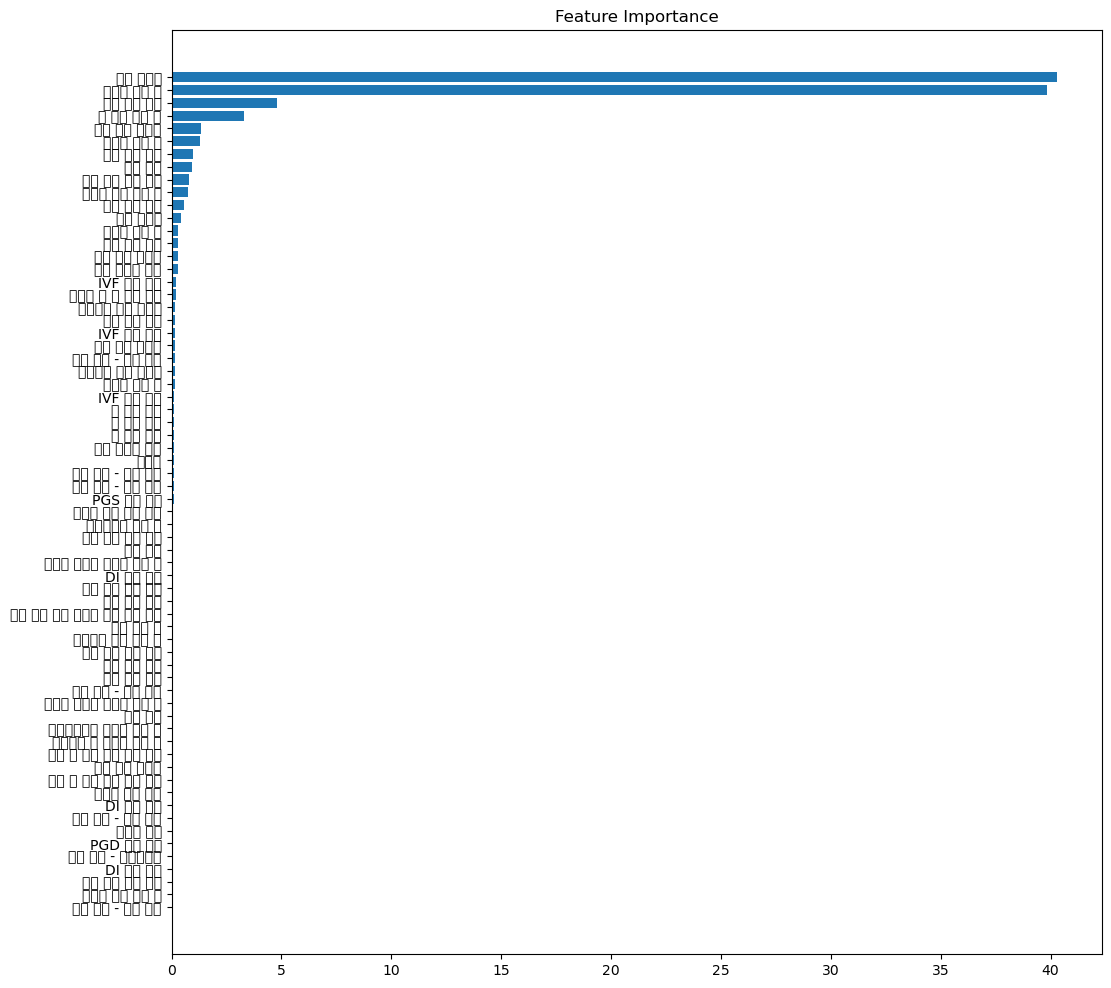

In [44]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [54]:
np.array(X.columns)[sorted_idx][::-1]

array(['배아 이식률', '이식된 배아 수', '시술 당시 나이', '총 생성 배아 수', '배아 이식 경과일',
       '저장된 배아 수', '저장 배아 비율', '난자 출처', '배아 생성 주요 이유', '수집된 신선 난자 수',
       '배란 자극 여부', '임신 성공률', '혼합된 난자 수', '시술 시기 코드', '해동 배아 생존율',
       '난자 기증자 나이', 'IVF 시술 횟수', '클리닉 내 총 시술 횟수', '미세주입 배아 생성률',
       '특정 시술 유형', 'IVF 임신 횟수', '배아 해동 경과일', '불임 원인 - 남성 요인',
       '미세주입 배아 이식률', '해동된 배아 수', 'IVF 출산 횟수', '총 출산 횟수', '총 임신 횟수',
       '총 시술 횟수', '정자 기증자 나이', '출산율', '불임 원인 - 여성 요인', '불임 원인 - 난관 질환',
       'PGS 시술 여부', '파트너 정자 혼합 비율', '미세주입된 난자 수', '동결 배아 사용 여부', '정자 출처',
       '파트너 정자와 혼합된 난자 수', 'DI 시술 횟수', '단일 배아 이식 여부', '남성 불임 원인',
       '임신 시도 또는 마지막 임신 경과 연수', '해동 난자 수', '미세주입 배아 이식 수', '신선 배아 사용 여부',
       '여성 불임 원인', '부부 불임 원인', '불임 원인 - 배란 장애', '기증자 정자와 혼합된 난자 수',
       '시술 유형', '미세주입에서 생성된 배아 수', '미세주입 후 저장된 배아 수', '착상 전 유전 검사 사용 여부',
       '난자 혼합 경과일', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', 'DI 출산 횟수',
       '불임 원인 - 정자 요인', '대리모 여부', 'PGD 시술 여부', '불임 원인 - 자궁내막증',
       'DI 임신 횟수', '기증 배아 사용 여부', '저장된 신선 난자

In [55]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13543.,  2355.,  3292.,  5911.,  9144., 13078., 16803., 15203.,
        10113.,   625.]),
 array([5.39478946e-04, 8.84577679e-02, 1.76376057e-01, 2.64294346e-01,
        3.52212635e-01, 4.40130924e-01, 5.28049213e-01, 6.15967501e-01,
        7.03885790e-01, 7.91804079e-01, 8.79722368e-01]),
 <BarContainer object of 10 artists>)

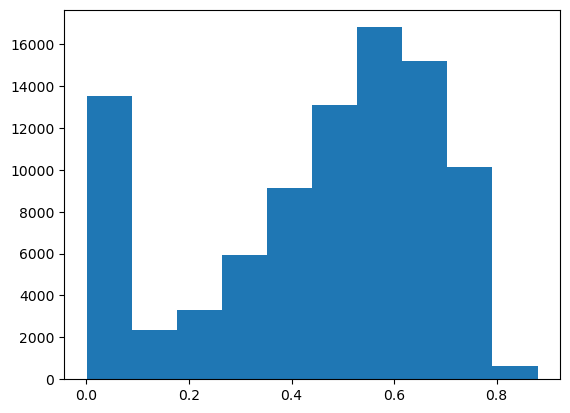

In [56]:
plt.hist(test_pred_total_mean)

In [57]:
sample_submission = pd.read_csv('/work/home/ybchae/aimers/aimers_data/sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean

In [58]:
sample_submission.to_csv('/work/home/ybchae/aimers/aimers_data/Add_feature_reason2_lgbmcat.csv', index=False)